# Infinite, Nonparametric Expectation Maximization

This notebook documents the first attempt in implementing 
the EM algorithm for Dirichlet process models.

At first, we plot the distribution that defines the stick breaking 
process and the influence of the hyper parameter $\alpha$ the *scaling parameter*

Text(0.5, 1.0, 'The beta distribution')

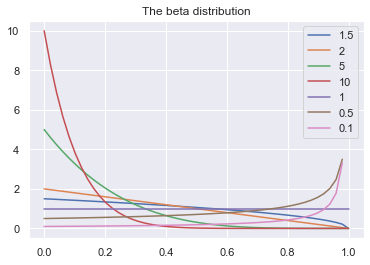

In [2]:
import seaborn as sns

from matplotlib import pyplot as plt
sns.set()

import numpy as np
%matplotlib inline

from scipy.stats import beta
x = np.linspace(0,1,50)
plt.plot(x,beta.pdf(x,1.5,1),'-',label='1.5')
plt.plot(x,beta.pdf(x,1,2),'-',label='2')
plt.plot(x,beta.pdf(x,1,5),'-',label='5')
plt.plot(x,beta.pdf(x,1,10),'-',label='10')
# plt.plot(x,beta.pdf(x,1,100),'-',label='100')
plt.plot(x,beta.pdf(x,1,1.0),'-',label='1')
plt.plot(x,beta.pdf(x,1,.5),'-',label='0.5')
plt.plot(x,beta.pdf(x,1,.1),'-',label='0.1')

plt.legend()
plt.title("The beta distribution")


(array([  1.,   1.,   1.,   2.,   1.,   1.,   0.,   2.,   5.,   3.,   3.,
          3.,   9.,   8.,  20.,  26.,  24.,  22.,  26.,  26.,  48.,  49.,
         76.,  95., 108., 125., 130., 185.]),
 array([0.48713025, 0.50544141, 0.52375257, 0.54206373, 0.56037489,
        0.57868605, 0.59699721, 0.61530837, 0.63361953, 0.65193069,
        0.67024186, 0.68855302, 0.70686418, 0.72517534, 0.7434865 ,
        0.76179766, 0.78010882, 0.79841998, 0.81673114, 0.8350423 ,
        0.85335346, 0.87166462, 0.88997578, 0.90828695, 0.92659811,
        0.94490927, 0.96322043, 0.98153159, 0.99984275]),
 <a list of 28 Patch objects>)

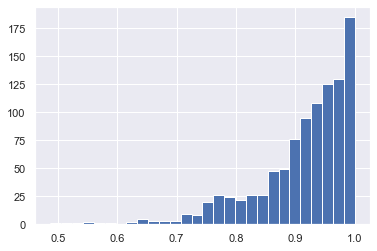

In [12]:
a = np.random.beta(10,1,1000)
plt.hist(a, bins='auto')

Then, we generate random data and try to learn a model.

{0: 24, 1: 16, 2: 24, 3: 16, 4: 17, 5: 20, 6: 23, 7: 21, 8: 15, 9: 24}


(200, 2)

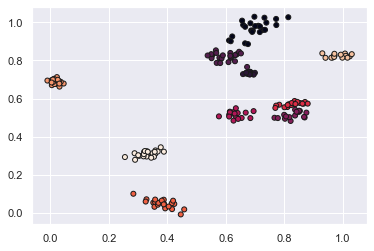

In [2]:
from kuberspatiotemporal.tools import make_gmm

n_clusters=10
X,_y,_ = make_gmm(200, n_clusters=n_clusters)

display(X.shape)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y,
            s=25, edgecolor='k')

## Involved formulas

We simplify and adjust the formulas for easy, vectorized implementation.

$$ \begin{array}{rclr}
\nu^{(t)}_i &=& \frac{a_i{(t)}}{a_i^{(t)} + \alpha - 1 + \sum_{l=i+1}^N a_l^{(t)}}\\
&=& \frac{a_i{(t)}}{\alpha - 1 + \sum_{l=i}^N a_l^{(t)}} & \text{Reduction step omitted in paper }\\
\nu^{(t)}_N &=& 1 & \text{important for the truncated case} \\ \\
\pi^{(t)}_i &=& \nu^{(t)}_i \prod_{j=1}^{i-1}\left(1-\nu^{(t)}_j\right) \\ 
&=& \frac{\nu^{(t)}_i \prod_{j=1}^{i}\left(1-\nu^{(t)}_j\right)}{(1-\nu^{(t)}_i)} & \qquad\text{Easier to implement with block operations.. But can result in division by zero}\\
\end{array}$$

The following two cells show the equivalency of different ways of writing the computation steps.
Ultimately, the optimal implementations end up in the final code.

In [3]:
import numpy as np

# Some dummy values
sufficient_statistics_0 = np.arange(5)+1
n_components = 5
priors = np.zeros(n_components); 
alpha = 0.5

# Method 1 (naive, with loop)
for i,a in enumerate(sufficient_statistics_0):
    priors[i] = a / ( alpha - 1 + np.sum(sufficient_statistics_0[i:]) )
display(priors)

# Method 2: without loops (optimized but not very readable)
priors = sufficient_statistics_0 / ( alpha - 1 + np.flip(np.cumsum(np.flip(sufficient_statistics_0))) )
display(priors)


array([0.06896552, 0.14814815, 0.26086957, 0.47058824, 1.11111111])

array([0.06896552, 0.14814815, 0.26086957, 0.47058824, 1.11111111])

In [17]:
priors = np.random.random(n_components)
priors[-1]=1.0
print("Dummy values for priors:", priors)

# Method 1 (naive, with loop)
weights = np.zeros(n_components)
for i in range(n_components):
    weights[i] = priors[i] * np.prod(1- priors[:i])
print(weights,np.sum(weights))

# Method 2: without loops (copies, first element needs to be assigned seperatedly)
weights = np.zeros(priors.shape)
weights[0] = priors[0]
weights[1:] = priors[1:] * np.cumprod(1 - priors)[:-1]

print(weights, np.sum(weights))

# Method 3: without loops (readable, based on the modified formula above)
# Apparently the coolest (1 liner). However, division by zero occurs if one of the values is 1
# This is the case for the last value!
weights = priors * np.cumprod(1 - priors) / (1-priors)
print(weights)



Dummy values for priors: [0.741 0.048 0.84  0.815 1.   ]
[0.741 0.012 0.207 0.032 0.007] 1.0
[0.741 0.012 0.207 0.032 0.007] 1.0
[0.741 0.012 0.207 0.032   nan]


/Users/stef/Library/Caches/pypoetry/virtualenvs/kuberspatiotemporal-Oap4g_bh-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


The final implementation looks like this:

In [5]:
from typing import List, Optional, Callable, Tuple
import logging
from scipy.stats import multivariate_normal as mvn
from sklearn.datasets import make_spd_matrix
import numpy as np
from numpy.random import random_sample
import attr
from matplotlib import pyplot as plt
import matplotlib as mpl
import sys

from kuberspatiotemporal.tools import (
    check_spd, 
    check_singular,
    make_ellipses,
    repr_list_ndarray
)

%matplotlib inline

# Always useful: https://stackoverflow.com/a/44401529
logging.basicConfig(format='[%(funcName)s:%(lineno)d] %(message)s')
logger = logging.getLogger(__name__)

logger.setLevel(logging.DEBUG)
    
    
    
def make_ellipses(gmm: 'GaussianMixtureModel', ax, min_weight=.0):
    """Shamelessly stolen from
    https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html"""

    # pylint: disable=invalid-name

    if not True:
        raise NotImplementedError("Matplotlib not available")

    colors = ['navy', 'turquoise', 'darkorange','firebrick',
              'yellowgreen', 'mediumorchid','slateblue',
              'darkcyan','gold','mediumpurple','navajowhite']*10

    for n, color in enumerate(colors):
        
        if n==gmm.n_components:
            break
            
        if gmm.weights[n] < min_weight:
            continue
        
        covariances = gmm.covs[n]
        

        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means[n], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')

##################
# dpm.py
##################

@attr.s
class GaussianMixtureModel:

    # public attributes
    n_components: int = attr.ib()
    n_dim: int = attr.ib(default=2)
    alpha: float = attr.ib(default=0.75)
    start_maximimization: int = attr.ib(default=5)
    nonparametric: bool = attr.ib(default=True)
    scaling_parameter: float = attr.ib(default=2.0)

    # Internal state variables
    counter: int = attr.ib(default=0)  # This is intended for resuming
    # TODO consider the model to be numpy arrays instead of lists
    priors: Optional[np.ndarray] = attr.ib(default=None, repr=lambda x: f"Array {x.shape}" if x is not None else "None")
    weights: List[float] = attr.ib(factory=list, repr=lambda x: f"`list of length {len(x)}`")
    means: List[np.ndarray] = attr.ib(factory=list, repr=lambda x: repr_list_ndarray)
    covs: List[np.ndarray] = attr.ib(factory=list, repr=lambda x: repr_list_ndarray)
    sufficient_statistics: List[np.ndarray] = attr.ib(factory=list, repr=lambda x: repr_list_ndarray)
    cached_regularization: Optional[np.ndarray] = attr.ib(default=None, repr=False)
    #init_means: Callable[[np.ndarray,np.ndarray,Tuple[int,int]],np.ndarray] = attr.ib(
    #    # default=lambda low,up,shape: (low - up) * np.random.randrandom_sample(shape) + low,
    #    default=lambda shape: np.random.randrandom_sample(shape),
    #    repr=False
    #)
    limits: Tuple[np.ndarray,np.ndarray] = attr.ib(default=None) # should have a validator
        
    def __attrs_post_init__(self):
        if not self.limits:
            self.limits = (np.zeros(self.n_dim),np.ones(self.n_dim))
            
        if not self.weights:
            self.weights = np.ones((self.n_components,)) * 1.0 / self.n_components
#             rand = np.random.random((self.n_components,))
#             self.weights = (rand / np.sum(rand)).tolist()
        if not self.means:
            self.means = [np.random.random_sample((self.n_dim,))
                          for i in range(self.n_components)]
        if not self.covs:
#             self.covs = [make_spd_matrix(self.n_dim) * 0.01
#                          for i in range(self.n_components)]
            self.covs = [np.identity(self.n_dim) * 0.01
                         for i in range(self.n_components)]
        if not self.sufficient_statistics:
            self.sufficient_statistics = [
                np.zeros((self.n_components,)),
                np.zeros((self.n_components, self.n_dim)),
                np.zeros((self.n_components, self.n_dim, self.n_dim))
            ]
        if not self.priors:
            self.priors = np.zeros((self.n_components,))
        
        if not self.cached_regularization:
            self.cached_regularization = np.identity(self.n_dim)*1e-6
            
        logger.info('GMM initiailized')

    def random_sample(self, n: int) -> np.ndarray:
        low = self.limits[0][:,np.newaxis]
        up = self.limits[1][:,np.newaxis]
        
        return (low - up) * np.random.random((n,self.n_dim)) + low
        
    def random_cov(self) -> np.ndarray:
        return np.identity(self.n_dim)*0.01
    
    def expect(self, data: np.ndarray) -> List[List[float]]:


        for i,cov in enumerate(self.covs):
            if check_singular(cov, 1e5):
                logger.error('Found singular matrix: replacing')
                logger.info('Corresponding weight: %s', self.weights[i])
                logger.info('All weights: %s', self.weights)
                logger.info('Corresponding s0: %s', self.sufficient_statistics[0][i])
                logger.info('All s0: %s', self.sufficient_statistics[0])
                self.covs[i] = np.eye(self.n_dim)*0.001 
                

        responsibilities = []
        for t in range(data.shape[0]):
            try:
                
                denominator = np.sum([self.weights[i] * mvn.pdf(data[t],
                                                                self.means[i],
                                                                self.covs[i])
                                      for i in range(self.n_components)])

                row = [self.weights[i] / denominator
                              * mvn.pdf(data[t],
                                        self.means[i],
                                        self.covs[i])
                              for i in range(self.n_components)]
            except np.linalg.LinAlgError as err:
                logger.exception("Failed to compute the responsibilities, %s,\n%s,\n%s",
                                 err, [np.linalg.cond(x) for x in self.covs],
                                 [np.linalg.cond(x)>1e11 for x in self.covs])

            responsibilities.append(row)

        return responsibilities

    def predict(self, data: np.ndarray) -> np.ndarray:
        responsibilities = np.asarray(self.expect(data))
        return np.argmax(responsibilities,axis=1), responsibilities

        
        
    def maximize(self, data, responsibilities):

        ########################################
        #
        # Nonparametric implementation
        #
        ########################################
        
        if not self.nonparametric:
            weights = self.sufficient_statistics[0] / np.sum(self.sufficient_statistics[0])
        else:
            self.priors = self.sufficient_statistics[0] / ( 
                self.scaling_parameter - 1 + np.flip(np.cumsum(np.flip(self.sufficient_statistics[0]))) 
            )
            self.priors[-1] = 1.0 # truncate

            weights = np.empty(self.priors.shape)
            weights[0] = self.priors[0]
            weights[1:] = self.priors[1:] * np.cumprod(1 - self.priors)[:-1]
            
        ########################################

        if False:
            n_samples = data.shape[0]
            
            means = (
                np.sum( data[:,np.newaxis,:] * responsibilities[:,:,np.newaxis], axis=0) 
                / (weights[:,np.newaxis] * n_samples)
            )
            covs = (
                np.sum(
                    np.einsum('Ti,Tj->Tij', data, data)[:,np.newaxis,:,:] * 
                    responsibilities[:,:,np.newaxis,np.newaxis] /
                    (weights[:,np.newaxis,np.newaxis] * n_samples), # n_samples x n_components x n_dim x n_dim
                    axis=0
                ) -
                np.einsum('ki,kj->kij', means2, means2) # n_components x n_dim x n_dim
            ) + self.cached_regularization[np.newaxis,:,:]

        else:
            with np.errstate(divide='ignore',invalid='ignore'): 
            
                means = self.sufficient_statistics[1] / self.sufficient_statistics[0][:, np.newaxis]
            
            # suppress div by zero warinings (occur naturally for disabled components)
                covs = (
                    self.sufficient_statistics[2] / self.sufficient_statistics[0][:, np.newaxis, np.newaxis]
                    - np.einsum('ki,kj->kij', means, means)
                )  + self.cached_regularization[np.newaxis,:,:]

#         TODO: reassigning will be helpful either way
#         if not nonparametric:
#             covs += self.cached_regularization[np.newaxis,:,:]
            
#         logger.info(f"Difference means: {((means - means2)**2).mean()}")
#         logger.info(f"Difference covs: {((covs - covs2)**2).mean()}") #practically zero
        
        self.weights = weights.tolist()
        self.means = [i for i in means]
        self.covs = [i for i in covs] 
        

        for i, cov in enumerate(self.covs):
            
            if self.sufficient_statistics[0][i] < self.n_dim +1:
                self.weights[i] = 0.0
                self.means[i] = np.ones(self.n_dim) * 0.0
                self.covs[i] = np.identity(self.n_dim) * 0.01
            else:
                
            
                if (
                    # self.weights[i] <= 3/self.counter/self.n_components or
                    np.allclose(cov,0.0,atol=1e-4) # collapsed. atol Maybe a parameter?
                    or np.any(np.isnan(cov))
                ): 
                    logger.debug("Reset component %s, weight: %.6f, s0: %.6f, %.6f", 
                                 cov, self.weights[i],self.sufficient_statistics[0][i],
                                 3/self.counter/self.n_components)
                    self.means[i] = np.random.random(self.n_dim,) #self.random_sample(1)
                    self.covs[i] = self.random_cov()
                    self.weights[i] = np.random.random()

                elif not check_spd(cov) or check_singular(cov, 1e5):
    #                     logger.warning("Sufficient statistics for component %d:\n%s,\n%s\nweights: %s", i,
    #                                 [j[i] for j in self.sufficient_statistics], self.sufficient_statistics[0],self.weights)
                    logger.error('You should not be here! Reset component %s, weight: %.6f, weight: %.6f', 
                                 cov, self.weights[i],self.sufficient_statistics[0][i])

                    self.covs[i] = np.eye(2)*0.01
                    self.covs[i] = self.random_cov()
                    self.weights[i] = np.random.random()
                    #self.means[i] = np.array([-1,-1])

    
    
    def batch(self, data: np.ndarray):

        n_samples = data.shape[0]
        self.counter = n_samples
        
        responsibilities = np.asarray(self.expect(data))

        self.sufficient_statistics[0] = np.sum(
            responsibilities,  # (n_samples, n_components)
            axis=0
        )

        self.sufficient_statistics[1] = np.sum(
            responsibilities[:, :, np.newaxis] * data[:, np.newaxis, :],  # (n_samples, n_components, n_dim)
            axis=0
        )

        self.sufficient_statistics[2] = np.sum(
            responsibilities[:, :, np.newaxis, np.newaxis] *
            np.einsum('Ti,Tj->Tij', data, data)[:, np.newaxis, :, :],  # (n_samples, n_components, n_dim, n_dim)
            axis=0
        )
        self.maximize(data, responsibilities)


    def incremental(self, data: np.ndarray):


        for sample in data:

            self.counter += 1

            responsibilities = np.asarray(self.expect(sample.reshape(1, -1))).reshape(-1)

            rate = (self.counter+1)**(-self.alpha)

            # First reduce the influence of the older samples
            for i in self.sufficient_statistics:
                i *= (1-rate)

            # Then introduce the new sample
            self.sufficient_statistics[0] += (
                rate * responsibilities
            )

            self.sufficient_statistics[1] += (
                rate * responsibilities[:, np.newaxis] * sample[np.newaxis, :]
            )

            self.sufficient_statistics[2] += (
                rate * responsibilities[:, np.newaxis, np.newaxis] *
                np.einsum('i,j->ij', sample, sample)[np.newaxis, :, :]
            )

            if self.counter > self.start_maximimization:
                self.maximize()

    def fit(self, data: np.ndarray, n_iterations=100, online=False):

        if len(data.shape) != 2:
            raise ValueError(f"Wrong input dimensions (at least 2D)")

        if data.shape[1] != self.n_dim:
            raise ValueError(f"Wrong input dimensions {data.shape[1]} != {self.n_dim} ")

        if data.shape[0] == 0:
            logger.info("Empty data set")
            return
        logger.info("Learning %d samples (%s)", data.shape[0],
                     "Online" if online else "Batch")

        for i in range(n_iterations):
            if i % 10 == 0:
                logger.info('Step %d/%d', i, n_iterations)
            if online:
                self.incremental(data)
            else:
                self.batch(data)

    def get_logger(self):
        return logger
            
            

## Experiment

In this experiment, we use the data generated earlier and train the model that we just have defined.

[__attrs_post_init__:124] GMM initiailized
[fit:342] Learning 200 samples (Batch)
[fit:346] Step 0/1


sorted weights [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01]
sorted weights [0.    0.018 0.    0.    0.    0.    0.    0.    0.    0.    0.07  0.
 0.022 0.    0.027 0.058 0.02  0.    0.    0.    0.018 0.    0.    0.
 0.018 0.    0.    0.    0.    0.    0.    0.027 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.019 0.023 0.
 0.    0.    0.033 0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.017 0.02  0.    0.    0.02  0.    0.017 0.    0.    0.    0.027
 0.    0.    0.018 0.    0.    0.016 0

[fit:342] Learning 200 samples (Batch)
[fit:346] Step 0/1


sorted weights [0.    0.018 0.    0.    0.    0.    0.    0.    0.    0.    0.097 0.
 0.038 0.    0.035 0.074 0.    0.    0.    0.    0.026 0.    0.    0.
 0.017 0.    0.    0.    0.    0.    0.    0.078 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.038 0.015 0.
 0.    0.    0.067 0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.027 0.027 0.    0.    0.029 0.    0.039 0.    0.    0.    0.042
 0.    0.    0.037 0.    0.    0.05  0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.034 0.06  0.023 0.    0.016 0.
 0.    0.    0.044 0.046]
Sufficient statistics 0 [ 0.     3.558  0.     0.     0.     0.     0.     0.     0.     0.
 19.373  0.     7.565  0.     6.978 14.746  2.648  0.     0.     0.
  5.132  0.     0.     0.     3.359  0.     0.     0.     0.     0.
  0.    15.606  0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     7.527  3.04   0.     0.     0.
 13.473  0.     0.     0.     0.

[fit:342] Learning 200 samples (Batch)
[fit:346] Step 0/1


sorted weights [0.    0.02  0.    0.    0.    0.    0.    0.    0.    0.    0.114 0.
 0.038 0.    0.02  0.083 0.    0.    0.    0.    0.036 0.    0.    0.
 0.017 0.    0.    0.    0.    0.    0.    0.116 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.038 0.    0.
 0.    0.    0.067 0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.032 0.    0.    0.    0.023 0.    0.04  0.    0.    0.    0.025
 0.    0.    0.037 0.    0.    0.057 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.019 0.079 0.    0.    0.    0.
 0.    0.    0.046 0.053]
Sufficient statistics 0 [ 0.     3.973  0.     0.     0.     0.     0.     0.     0.     0.
 22.855  0.     7.662  0.     4.056 16.632  0.     0.     0.     0.
  7.285  0.     0.     0.     3.487  0.     0.     0.     0.     0.
  0.    23.141  0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     7.529  1.449  0.     0.     0.
 13.471  0.     0.     0.     0.

[fit:342] Learning 200 samples (Batch)
[fit:346] Step 0/1


sorted weights [0.    0.02  0.    0.    0.    0.    0.    0.    0.    0.    0.127 0.
 0.038 0.    0.    0.088 0.    0.    0.    0.    0.037 0.    0.    0.
 0.018 0.    0.    0.    0.    0.    0.    0.139 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.038 0.    0.
 0.    0.    0.067 0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.034 0.    0.    0.    0.    0.    0.04  0.    0.    0.    0.018
 0.    0.    0.037 0.    0.    0.062 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.089 0.    0.    0.    0.
 0.    0.    0.056 0.058]
Sufficient statistics 0 [ 0.     4.043  0.     0.     0.     0.     0.     0.     0.     0.
 25.364  0.     7.657  0.     1.933 17.653  0.     0.     0.     0.
  7.397  0.     0.     0.     3.56   0.     0.     0.     0.     0.
  0.    27.882  0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     7.536  0.     0.     0.     0.
 13.464  0.     0.     0.     0.

[fit:342] Learning 200 samples (Batch)
[fit:346] Step 0/1


sorted weights [0.    0.02  0.    0.    0.    0.    0.    0.    0.    0.    0.128 0.
 0.038 0.    0.    0.09  0.    0.    0.    0.    0.037 0.    0.    0.
 0.018 0.    0.    0.    0.    0.    0.    0.152 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.038 0.    0.
 0.    0.    0.067 0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.036 0.    0.    0.    0.    0.    0.041 0.    0.    0.    0.017
 0.    0.    0.036 0.    0.    0.062 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.096 0.    0.    0.    0.
 0.    0.    0.067 0.058]
Sufficient statistics 0 [ 0.     4.03   0.     0.     0.     0.     0.     0.     0.     0.
 25.634  0.     7.633  0.     0.    17.904  0.     0.     0.     0.
  7.377  0.     0.     0.     3.593  0.     0.     0.     0.     0.
  0.    30.414  0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     7.548  0.     0.     0.     0.
 13.452  0.     0.     0.     0.

[fit:342] Learning 200 samples (Batch)
[fit:346] Step 0/1


sorted weights [0.    0.02  0.    0.    0.    0.    0.    0.    0.    0.    0.128 0.
 0.038 0.    0.    0.084 0.    0.    0.    0.    0.037 0.    0.    0.
 0.018 0.    0.    0.    0.    0.    0.    0.16  0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.038 0.    0.
 0.    0.    0.067 0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.036 0.    0.    0.    0.    0.    0.041 0.    0.    0.    0.
 0.    0.    0.036 0.    0.    0.062 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.09  0.    0.    0.    0.
 0.    0.    0.072 0.058]
Sufficient statistics 0 [ 0.     4.008  0.     0.     0.     0.     0.     0.     0.     0.
 25.603  0.     7.622  0.     0.    16.856  0.     0.     0.     0.
  7.31   0.     0.     0.     3.682  0.     0.     0.     0.     0.
  0.    32.083  0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     7.567  0.     0.     0.     0.
 13.433  0.     0.     0.     0.   

[fit:342] Learning 200 samples (Batch)
[fit:346] Step 0/5
[maximize:255] Reset component [[ 0. -0.]
 [-0.  0.]], weight: 0.081316, s0: 16.263210, 0.000150


sorted weights [0.    0.021 0.    0.    0.    0.    0.    0.    0.    0.    0.103 0.
 0.045 0.    0.    0.086 0.    0.    0.    0.    0.032 0.    0.    0.
 0.022 0.    0.    0.    0.    0.    0.    0.178 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.039 0.    0.
 0.    0.    0.066 0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.015 0.    0.    0.    0.    0.    0.039 0.    0.    0.    0.
 0.    0.    0.031 0.    0.    0.062 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.083 0.    0.    0.    0.
 0.    0.    0.12  0.058]
Sufficient statistics 0 [ 0.     4.195  0.     0.     0.     0.     0.     0.     0.     0.
 20.584  0.     8.995  0.     0.    17.145  0.     0.     0.     0.
  6.325  0.     0.     0.     4.48   0.     0.     0.     0.     0.
  0.    35.609  0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     7.87   0.     0.     0.     0.
 13.13   0.     0.     0.     0.   

[fit:342] Learning 200 samples (Batch)
[fit:346] Step 0/5


sorted weights [0.    0.022 0.    0.    0.    0.    0.    0.    0.    0.    0.099 0.
 0.053 0.    0.    0.107 0.    0.    0.    0.    0.027 0.    0.    0.
 0.026 0.    0.    0.    0.    0.    0.    0.18  0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.043 0.    0.
 0.    0.    0.062 0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.028 0.    0.    0.    0.    0.    0.032 0.    0.    0.    0.
 0.    0.    0.03  0.    0.    0.06  0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.085 0.    0.    0.    0.
 0.    0.    0.086 0.06 ]
Sufficient statistics 0 [ 0.     4.348  0.     0.     0.     0.     0.     0.     0.     0.
 19.781  0.    10.639  0.     0.    21.32   0.     0.     0.     0.
  5.374  0.     0.     0.     5.278  0.     0.     0.     0.     0.
  0.    36.002  0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     8.631  0.     0.     0.     0.
 12.369  0.     0.     0.     0.   

[fit:342] Learning 200 samples (Batch)
[fit:346] Step 0/5
[maximize:255] Reset component [[ 0. -0.]
 [-0.  0.]], weight: 0.084991, s0: 16.998199, 0.000150


sorted weights [0.    0.025 0.    0.    0.    0.    0.    0.    0.    0.    0.096 0.
 0.057 0.    0.    0.112 0.    0.    0.    0.    0.018 0.    0.    0.
 0.033 0.    0.    0.    0.    0.    0.    0.18  0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.048 0.    0.
 0.    0.    0.057 0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.025 0.    0.    0.    0.    0.    0.027 0.    0.    0.    0.
 0.    0.    0.031 0.    0.    0.06  0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.085 0.    0.    0.    0.
 0.    0.    0.087 0.06 ]
Sufficient statistics 0 [ 0.     4.957  0.     0.     0.     0.     0.     0.     0.     0.
 19.144  0.    11.416  0.     0.    22.402  0.     0.     0.     0.
  3.505  0.     0.     0.     6.538  0.     0.     0.     0.     0.
  0.    36.002  0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     9.557  0.     0.     0.     0.
 11.443  0.     0.     0.     0.   

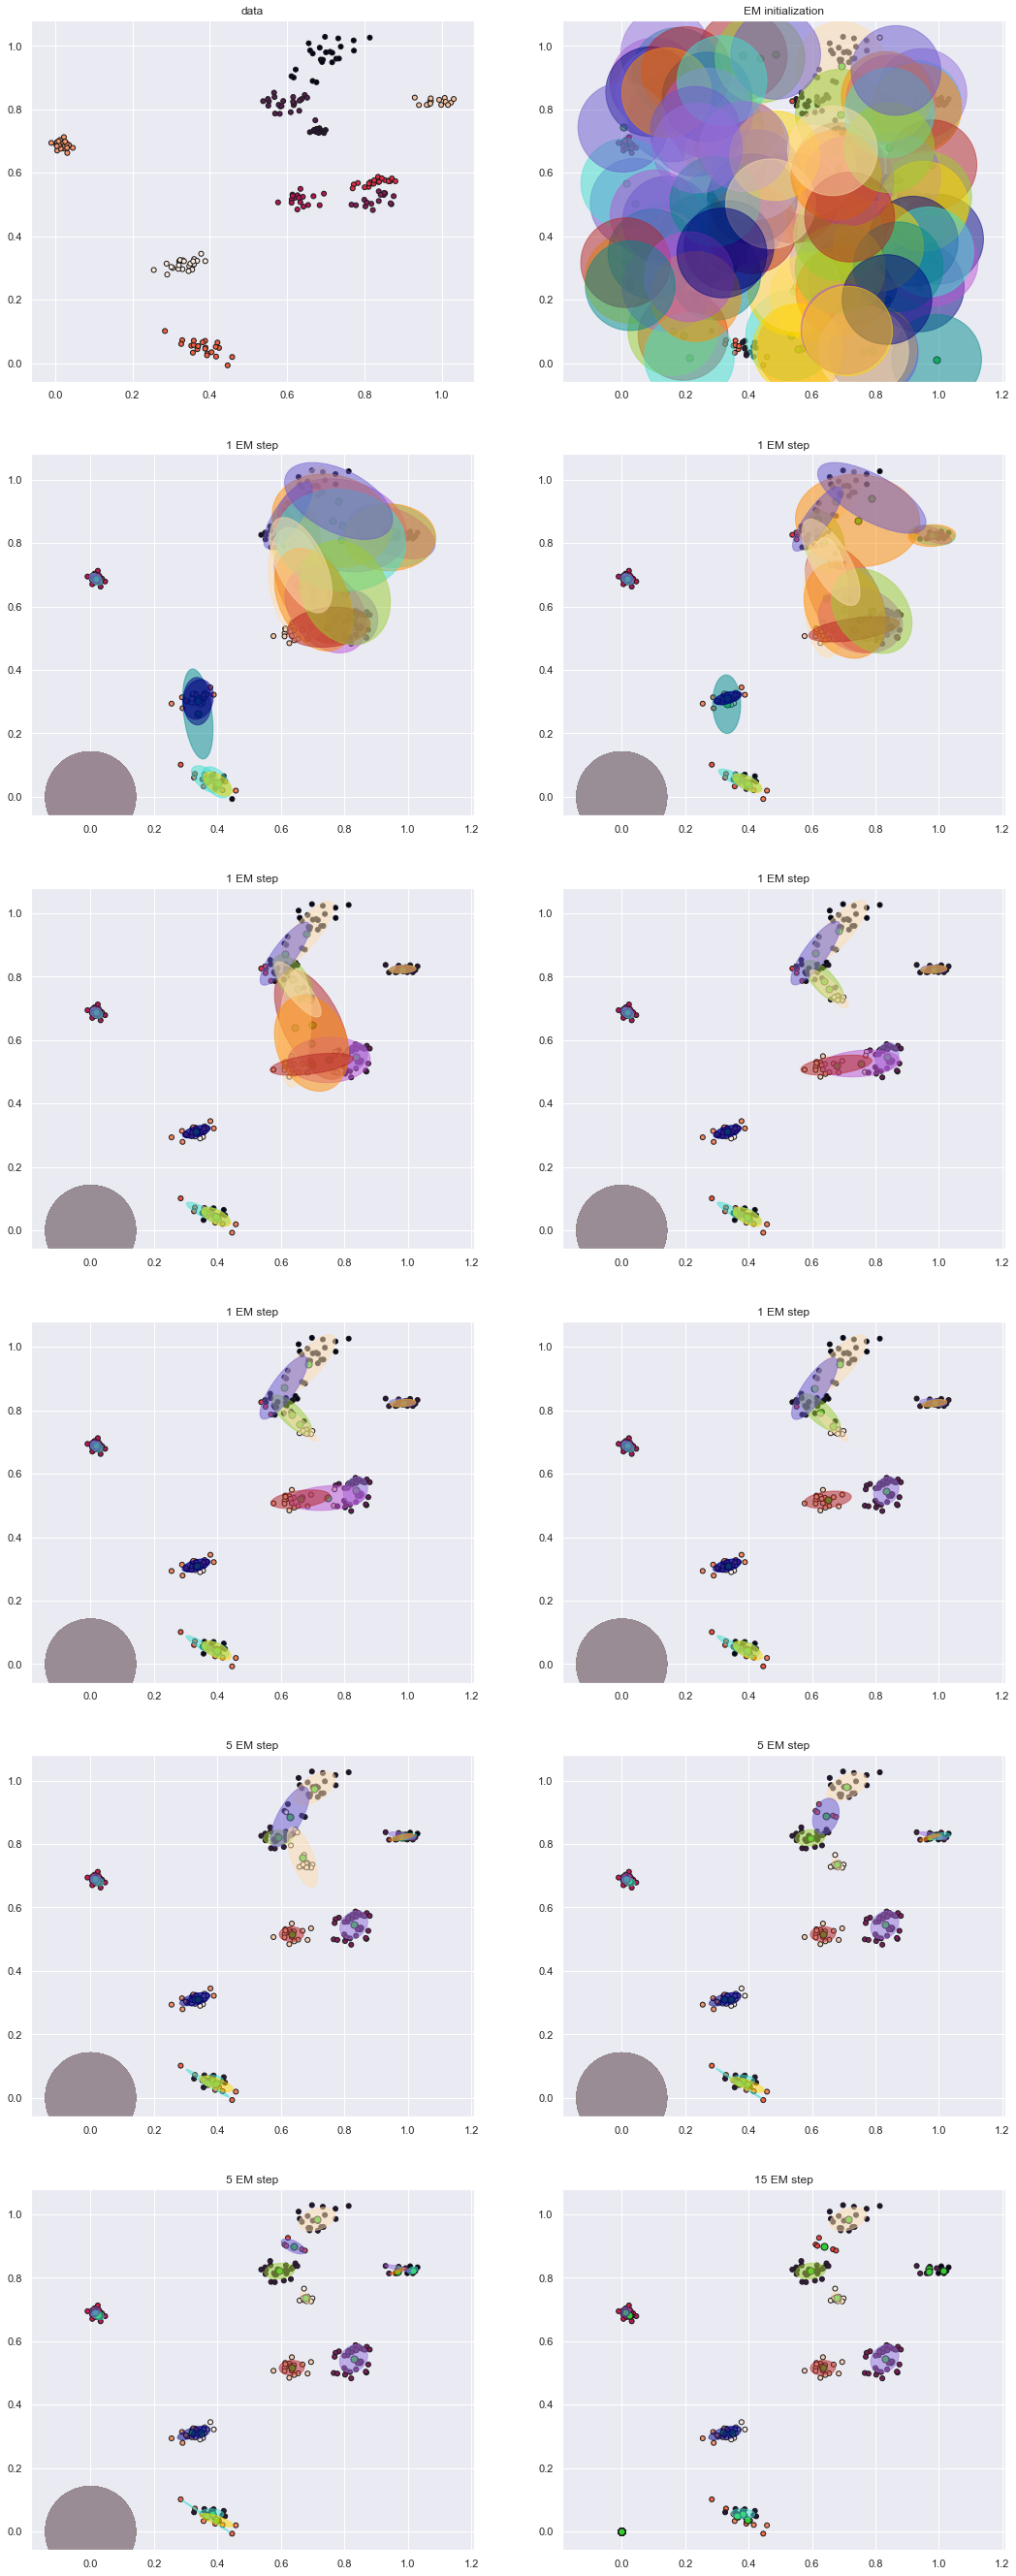

In [6]:
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), 
    (ax7, ax8), (ax9, ax10), (ax11, ax12) ) = plt.subplots(6,2, figsize=(18, 48))

np.set_printoptions(suppress=True)
np.set_printoptions(precision=3)



gmm = GaussianMixtureModel(n_components=100, nonparametric=True, scaling_parameter=1)

ax1.scatter(X[:, 0], X[:, 1], marker='o', c=y[:],
            s=25, edgecolor='k')
ax1.set_title('data')

# step 0 - initialization
make_ellipses(gmm, ax2)
p,r = gmm.predict(X)
# print(p,r)
means = np.asarray(gmm.means)
ax2.scatter(X[:, 0], X[:, 1], marker='o', c=gmm.predict(X)[0],
            s=25, edgecolor='k')

ax2.scatter(means[:, 0], means[:, 1], marker='o', c='limegreen',
            s=50, edgecolor='k')
ax2.set_title('EM initialization')
print("sorted weights", np.asarray(gmm.weights))

# step 1 - one EM

for axi in [ax3,ax4,ax5,ax6,ax7,ax8]:
    gmm.fit(X,n_iterations=1)
    print("sorted weights", np.asarray(gmm.weights))
    print("Sufficient statistics 0", gmm.sufficient_statistics[0])
    make_ellipses(gmm, axi)
    
    means = np.asarray(gmm.means)
    axi.scatter(X[:, 0], X[:, 1], marker='o', c=gmm.predict(X)[0],
                s=25, edgecolor='k')

    axi.scatter(means[:, 0], means[:, 1], marker='o', c='limegreen',
                s=50, edgecolor='k')
    axi.set_title('1 EM step')

for axi in [ax9,ax10,ax11]:
    gmm.fit(X,n_iterations=5)
    print("sorted weights", np.asarray(gmm.weights))
    print("Sufficient statistics 0", gmm.sufficient_statistics[0])
    
    print(np.sort(gmm.weights))
    make_ellipses(gmm, axi)
    
    means = np.asarray(gmm.means)
    axi.scatter(X[:, 0], X[:, 1], marker='o', c=gmm.predict(X)[0],
                s=25, edgecolor='k')

    axi.scatter(means[:, 0], means[:, 1], marker='o', c='limegreen',
                s=50, edgecolor='k')
    axi.set_title('5 EM step')

for axi in [ax12]:

    print("sorted weights", np.asarray(gmm.weights))
    print("Sufficient statistics 0", gmm.sufficient_statistics[0],np.sum(gmm.sufficient_statistics[0]))
    
    print(np.sort(gmm.weights))
    make_ellipses(gmm, axi, min_weight=0.05)
    
    means = np.asarray(gmm.means)
    axi.scatter(X[:, 0], X[:, 1], marker='o', c=gmm.predict(X)[0],
                s=25, edgecolor='k')

    axi.scatter(means[:, 0], means[:, 1], marker='o', c='limegreen',
                s=50, edgecolor='k')
    axi.set_title('15 EM step')
    